## MNIST画像認識

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# 画像ファイルを読み込むための準備(Channel x H x W)
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNISTダウンロード
train = torchvision.datasets.MNIST(
    root='.', 
    train=True,
    download=True,
    transform=transform)

print(len(train), type(train))

60000 <class 'torchvision.datasets.mnist.MNIST'>


In [2]:
train[0][0].shape

torch.Size([1, 28, 28])

正解ラベル： 5


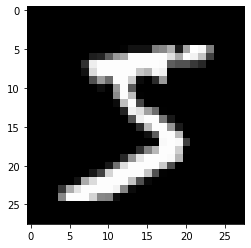

In [3]:
import numpy as np
import matplotlib.pyplot as plt

img = np.transpose(train[0][0], (1, 2, 0))
img = img.reshape(img.shape[0], img.shape[1])
print("正解ラベル：", train[0][1])
plt.imshow(img, cmap='gray')

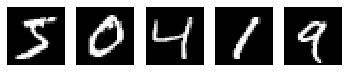

In [4]:
for i in range(5):
    img = np.transpose(train[i][0], (1, 2, 0))
    img = img.reshape(img.shape[0], img.shape[1])
    #print("正解ラベル：", train[i][1])
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
# 畳み込み層の定義
conv = nn.Conv2d(
    in_channels=1, 
    out_channels=4,
    kernel_size=3,
    stride=1,
    padding=1)
print(conv)

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [6]:
print(conv.weight, conv.bias)

Parameter containing:
tensor([[[[ 0.1112,  0.2471, -0.0391],
          [-0.3307, -0.0914,  0.0299],
          [ 0.2502, -0.0618, -0.0576]]],


        [[[ 0.1015, -0.2189,  0.2060],
          [-0.0596,  0.1144,  0.0038],
          [-0.1717, -0.2073, -0.0428]]],


        [[[-0.1699, -0.2177, -0.1648],
          [-0.1264, -0.0615, -0.3004],
          [ 0.1954, -0.0544, -0.1169]]],


        [[[-0.1463, -0.1345, -0.2116],
          [-0.1279, -0.2368,  0.1579],
          [ 0.0547,  0.1756,  0.1841]]]], requires_grad=True) Parameter containing:
tensor([-0.2266, -0.0604, -0.2635,  0.2755], requires_grad=True)


In [7]:
# とりあえず画像一枚だけ畳み込んでみる（batchsize=1のイメージ）
x = train[0][0] # [1, 28, 28]
x = x.reshape(1, 1, 28, 28) # [1, 1, 28, 28]
x = conv(x) # [1, 4, 28, 28]

In [8]:
x.shape

torch.Size([1, 4, 28, 28])

In [9]:
print(x[0].shape)

torch.Size([4, 28, 28])


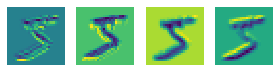

In [10]:
# 特徴マップの確認
for i in range(4):
    img2 = x[0][i].to('cpu').detach().numpy().copy()
    plt.subplot(1, 5, i+1)
    plt.imshow(img2)
    plt.axis('off')
plt.show()


In [11]:
# プーリング処理
x = F.max_pool2d(x, kernel_size=2, stride=2)

In [12]:
x.shape

torch.Size([1, 4, 14, 14])

In [13]:
# 全結合層の定義
x_shape = x.shape[1] * x.shape[2] * x.shape[3] # [784]
x_shape

784

In [14]:
x = x.view(-1, x_shape) # [1, 784]
x.shape

torch.Size([1, 784])

In [15]:
fc = nn.Linear(x_shape, 10) # 784 => 10

### PyTorch Lightningフレームワークを使って学習させる 

In [16]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# 画像ファイルを読み込むための準備(Channel x H x W)
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNISTダウンロード
train = torchvision.datasets.MNIST(
    root='.', 
    train=True,
    download=True,
    transform=transform)

print(len(train), type(train))

60000 <class 'torchvision.datasets.mnist.MNIST'>


In [17]:
# データセットの取得
transform = transforms.Compose([
    transforms.ToTensor()
])

train_val = torchvision.datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=transform)

test = torchvision.datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=transform)

In [18]:
# train : val = 80% : 20%
n_train = int(len(train_val) * 0.8)
n_val = len(train_val) - n_train

# データをランダムに分割
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

# 分割後のサンプル数を確認
len(train), len(val), len(test)

(48000, 12000, 10000)

In [19]:
train_val

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [20]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
# 学習データ用クラス
class TrainNet(pl.LightningModule):
    
    @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(train, self.batch_size, shuffle=True)
    
    def training_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        tensorboard_logs = {'train/train_loss': loss, 'train/train_acc': acc} # tensorboard
        results = {'loss': loss, 'log': tensorboard_logs}
        #results = {'loss': loss}
        return results

    
# 検証データ用クラス
class ValidationNet(pl.LightningModule):

    @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(val, self.batch_size)

    def validation_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'val_loss': loss, 'val_acc': acc}
        return results

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        tensorboard_logs = {'val/avg_loss': avg_loss, 'val/avg_acc': avg_acc}
        results = {'val_loss': avg_loss, 'val_acc': avg_acc, 'log': tensorboard_logs}        
        #results = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return results

    
# テストデータ用クラス
class TestNet(pl.LightningModule):

    @pl.data_loader
    def test_dataloader(self):
        return torch.utils.data.DataLoader(test, self.batch_size)

    def test_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'test_loss': loss, 'test_acc': acc}
        return results

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        tensorboard_logs = {'test/avg_loss': avg_loss, 'test/avg_acc': avg_acc}
        results = {'test_loss': avg_loss, 'test_acc': avg_acc, 'log': tensorboard_logs}            
        #results = {'test_loss': avg_loss, 'test_acc': avg_acc}
        return results

    
# 学習データ、検証データ、テストデータクラスの継承クラス
class Net(TrainNet, ValidationNet, TestNet):
    def __init__(self, input_size=784, hidden_size=100, output_size=10, batch_size=256):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1, stride=1)
        self.L1 = nn.Linear(input_size, hidden_size)
        self.L2 = nn.Linear(hidden_size, output_size)
        self.batch_size = batch_size
             
    def forward(self, x):
        x = self.conv(x)
        x = F.max_pool2d(x, 2, 2)
        #x = x.view(x.size(0), -1)
        x = x.view(-1, 784)
        x = self.L1(x)
        x = F.relu(x)
        x = self.L2(x)
        return x
    
    def lossfun(self, y, t):
        return F.cross_entropy(y, t)
        #return nn.CrossEntropyLoss(y, t)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.1)

In [21]:
# モデルのインスタンス化
net = Net()
net

Net(
  (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (L1): Linear(in_features=784, out_features=100, bias=True)
  (L2): Linear(in_features=100, out_features=10, bias=True)
)

In [22]:
# GPUで学習 max_epochs=50で十分
trainer = Trainer(max_epochs=100, gpus=1)

# モデルの学習
trainer.fit(net)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
C:\ProgramData\Anaconda3\envs\Pytorch\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\envs\Pytorch\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
INFO:lightning:
  | Name | Type   | Params
----------------------------
0 | conv | Conv2d | 40    
1 | L1   | Linear | 78 K  
2 | L2   | Linear | 1 K   


C:\ProgramData\Anaconda3\envs\Pytorch\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

In [23]:
trainer.test()

--------------------------------------------------------------------------------
TEST RESULTS
{'test/avg_acc': 0.982128918170929,
 'test/avg_loss': 0.0836787223815918,
 'test_acc': 0.982128918170929,
 'test_loss': 0.0836787223815918}
--------------------------------------------------------------------------------



In [24]:
trainer.callback_metrics

{'loss': 0.0005755648016929626,
 'train/train_loss': 0.0005755648016929626,
 'train/train_acc': 1.0,
 'val_loss': 0.092271588742733,
 'val_acc': 0.9805518388748169,
 'val/avg_loss': 0.092271588742733,
 'val/avg_acc': 0.9805518388748169,
 'epoch': 99,
 'test_loss': 0.0836787223815918,
 'test_acc': 0.982128918170929,
 'test/avg_loss': 0.0836787223815918,
 'test/avg_acc': 0.982128918170929}

In [25]:
# パラメータの保存
torch.save(net.state_dict(), 'pytorch_mnist.pt')

In [26]:
# 保存したパラメータの読み込み
net = Net()
net.load_state_dict(torch.load('pytorch_mnist.pt'))

<All keys matched successfully>

正解ラベル： 7


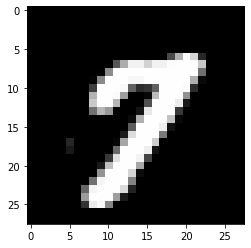

In [28]:
# 適当な画像をテストしてみる
import numpy as np
import random
import matplotlib.pyplot as plt

sample = test[random.randint(0, 10000)]
sample_label = sample[1]

img = np.transpose(sample[0], (1, 2, 0))
img = img.reshape(img.shape[0], img.shape[1])
print("正解ラベル：", sample_label)
plt.imshow(img, cmap='gray')

In [29]:
sample_img = sample[0].unsqueeze(0) # [1, 28, 28] > [1, 1, 28, 28] 
y_predict = net.forward(sample_img)
print(y_predict)
print("推論結果: ", y_predict.argmax())

tensor([[ -4.8887,   0.7164,  -3.8666,  -1.3102,   3.9630,  -9.4225, -24.2203,
          24.6791,   0.3872,   4.1036]], grad_fn=<AddmmBackward>)
推論結果:  tensor(7)


## CIFAR10画像認識
VGGっぽく畳み込む
Adam + Dropout

In [31]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer

In [32]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [33]:
# CIFAR10
train_val = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
# train : val = 8 : 2
n_train = int(len(train_val) * 0.8)
n_val = len(train_val) - n_train

In [35]:
# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# train と val を分割
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

In [36]:
len(train), len(val), len(test)

(40000, 10000, 10000)

In [37]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer

boardtag = "cifar10-"

# 学習データ用クラス
class TrainNet(pl.LightningModule):
    
    @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(train, self.batch_size, shuffle=True)
    
    def training_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        tensorboard_logs = {boardtag+'train/train_loss': loss, boardtag+'train/train_acc': acc} # tensorboard
        results = {'loss': loss, 'log': tensorboard_logs}
        #results = {'loss': loss}
        return results

    
# 検証データ用クラス
class ValidationNet(pl.LightningModule):

    @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(val, self.batch_size)

    def validation_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'val_loss': loss, 'val_acc': acc}
        return results

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        tensorboard_logs = {boardtag+'val/avg_loss': avg_loss, boardtag+'val/avg_acc': avg_acc}
        results = {'val_loss': avg_loss, 'val_acc': avg_acc, 'log': tensorboard_logs}        
        #results = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return results

    
# テストデータ用クラス
class TestNet(pl.LightningModule):

    @pl.data_loader
    def test_dataloader(self):
        return torch.utils.data.DataLoader(test, self.batch_size)

    def test_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'test_loss': loss, 'test_acc': acc}
        return results

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        #tensorboard_logs = {'test/avg_loss': avg_loss, 'test/avg_acc': avg_acc}
        #results = {'test_loss': avg_loss, 'test_acc': avg_acc, 'log': tensorboard_logs}            
        results = {'test_loss': avg_loss, 'test_acc': avg_acc}
        return results

In [38]:
# 学習データ、検証データ、テストデータクラスの継承クラス
class Net(TrainNet, ValidationNet, TestNet):
    def __init__(self, batch_size=256):
        super(Net, self).__init__()
        self.batch_size = batch_size
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.L2 = nn.Linear(2048, 128) 
        self.L1 = nn.Linear(128, 10) # 10クラス分類
        
        # *追加*
        self.dropout = nn.Dropout2d(p=0.5) 

        
    def forward(self, x):
        # 3ch > 64ch, shape 32 x 32 > 16 x 16
        x = self.conv1(x) # [64,32,32]
        #x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [64,16,16]
        
        # 64ch > 128ch, shape 16 x 16 > 8 x 8
        x = self.conv2(x) # [128,16,16]
        #x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [128,8,8]
        
        # 128ch > 256ch, shape 8 x 8 > 4 x 4
        x = self.conv3(x) # [256,8,8]
        #x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [256,4,4]   

        # 256ch > 512ch, shape 4 x 4 > 2 x 2
        x = self.conv4(x) # [512,4,4]
        #x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [512,2,2]   
        
        # 全結合層
        x = x.view( -1, 2048) # [256,2048]
        
        # *追加*
        #x = self.dropout(x)
        
        x = self.L2(x)
        x = F.relu(x)
        x = self.L1(x)
        
        return x
    
    def lossfun(self, y, t):
        return F.cross_entropy(y, t)
    
    def configure_optimizers(self):
        #return torch.optim.SGD(self.parameters(), lr=0.01)
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-3)

In [39]:
# 乱数のシードを固定
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)

net = Net()
net

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L2): Linear(in_features=2048, out_features=128, bias=True)
  (L1): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
)

In [40]:
trainer = Trainer(max_epochs=50, gpus=1)
trainer.fit(net)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name    | Type        | Params
------------------------------------
0  | conv1   | Conv2d      | 1 K   
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 73 K  
3  | bn2     | BatchNorm2d | 256   
4  | conv3   | Conv2d      | 295 K 
5  | bn3     | BatchNorm2d | 512   
6  | conv4   | Conv2d      | 1 M   
7  | bn4     | BatchNorm2d | 1 K   
8  | L2      | Linear      | 262 K 
9  | L1      | Linear      | 1 K   
10 | dropout | Dropout2d   | 0     


1

In [41]:
trainer.test()
trainer.callback_metrics

--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.748046875, 'test_loss': 1.0688246488571167}
--------------------------------------------------------------------------------



{'loss': 0.056562408804893494,
 'cifar10-train/train_loss': 0.056562408804893494,
 'cifar10-train/train_acc': 0.984375,
 'val_loss': 1.0891813039779663,
 'val_acc': 0.744921863079071,
 'cifar10-val/avg_loss': 1.0891813039779663,
 'cifar10-val/avg_acc': 0.744921863079071,
 'epoch': 49,
 'test_loss': 1.0688246488571167,
 'test_acc': 0.748046875}

In [42]:
# パラメータの保存
net = net.to('cpu')
torch.save(net.state_dict(), 'pytorch_cifar10_adamdrop.pt')

In [43]:
# 保存したパラメータの読み込み
net = Net()
net.load_state_dict(torch.load('pytorch_cifar10_adamdrop.pt'))

<All keys matched successfully>

正解ラベル： bird


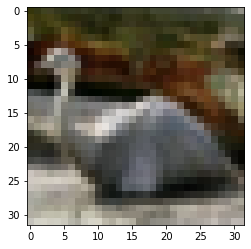

In [50]:
import numpy as np
import random
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  

#sample = test[random.randint(0, 10000)]
sample = train[random.randint(0, 10000)]
sample_label = sample[1]

img = np.transpose(sample[0], (1, 2, 0))
print("正解ラベル：", classes[sample[1]])
plt.imshow(img)

In [51]:
sample_img = sample[0].unsqueeze(0)
y_predict = net.forward(sample_img)
print(y_predict)
print("推論結果: ", classes[y_predict.argmax()])

tensor([[ 3.4250e-03, -3.4893e+00,  8.3722e+00, -6.2793e+00, -1.2277e+01,
         -4.8786e+00, -6.0389e+00, -8.5796e+00, -9.0479e+00, -7.8505e+00]],
       grad_fn=<AddmmBackward>)
推論結果:  bird


## RESNET 公開学習済みモデルの読み込み
CIFAR-10では学習効果あまり実感できず

In [52]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer

import numpy as np
import matplotlib.pyplot as plt

# 学習済みモデル
from torchvision.models import resnet18

resnet = resnet18(pretrained=True)

In [53]:
#RESNETの入力サイズに合わせる必要あり
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [54]:
train = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [55]:
train[0]

(tensor([[[-1.1075, -1.1075, -1.1075,  ...,  0.4166,  0.4166,  0.4166],
          [-1.1075, -1.1075, -1.1075,  ...,  0.4166,  0.4166,  0.4166],
          [-1.1075, -1.1075, -1.1075,  ...,  0.4166,  0.4166,  0.4166],
          ...,
          [ 0.9132,  0.9132,  0.9132,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.9132,  0.9132,  0.9132,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.9132,  0.9132,  0.9132,  ..., -0.0116, -0.0116, -0.0116]],
 
         [[-0.9503, -0.9503, -0.9503,  ...,  0.1352,  0.1352,  0.1352],
          [-0.9503, -0.9503, -0.9503,  ...,  0.1352,  0.1352,  0.1352],
          [-0.9503, -0.9503, -0.9503,  ...,  0.1352,  0.1352,  0.1352],
          ...,
          [ 0.4853,  0.4853,  0.4853,  ..., -0.4251, -0.4251, -0.4251],
          [ 0.4853,  0.4853,  0.4853,  ..., -0.4251, -0.4251, -0.4251],
          [ 0.4853,  0.4853,  0.4853,  ..., -0.4251, -0.4251, -0.4251]],
 
         [[-0.7064, -0.7064, -0.7064,  ..., -0.0092, -0.0092, -0.0092],
          [-0.7064, -0.7064,

In [56]:
# 一枚だけ抜き出してみる
x = train[0][0]
x.shape

torch.Size([3, 224, 224])

In [58]:
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 224, 224])

In [59]:
y = resnet(x)

In [60]:
# resnetが1000クラス分類用
y.shape

torch.Size([1, 1000])

In [61]:
# ファインチューニング用
train_val = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# データセットの分割
n_train = int(len(train_val) * 0.8)
n_val = len(train_val) - n_train
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

Files already downloaded and verified
Files already downloaded and verified


In [62]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer

boardtag = "cifar10-"

# 学習データ用クラス
class TrainNet(pl.LightningModule):
    
    @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(train, self.batch_size, shuffle=True)
    
    def training_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        tensorboard_logs = {boardtag+'train/train_loss': loss, boardtag+'train/train_acc': acc} # tensorboard
        results = {'loss': loss, 'log': tensorboard_logs}
        #results = {'loss': loss}
        return results

    
# 検証データ用クラス
class ValidationNet(pl.LightningModule):

    @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(val, self.batch_size)

    def validation_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'val_loss': loss, 'val_acc': acc}
        return results

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        tensorboard_logs = {boardtag+'val/avg_loss': avg_loss, boardtag+'val/avg_acc': avg_acc}
        results = {'val_loss': avg_loss, 'val_acc': avg_acc, 'log': tensorboard_logs}        
        #results = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return results

    
# テストデータ用クラス
class TestNet(pl.LightningModule):

    @pl.data_loader
    def test_dataloader(self):
        return torch.utils.data.DataLoader(test, self.batch_size)

    def test_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'test_loss': loss, 'test_acc': acc}
        return results

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        tensorboard_logs = {'test/avg_loss': avg_loss, 'test/avg_acc': avg_acc}
        results = {'test_loss': avg_loss, 'test_acc': avg_acc, 'log': tensorboard_logs}            
        #results = {'test_loss': avg_loss, 'test_acc': avg_acc}
        return results

In [63]:
# 学習データ、検証データ、テストデータクラスの継承クラス
class Net(TrainNet, ValidationNet, TestNet):
    def __init__(self, batch_size=256):
        super(Net, self).__init__()
        self.batch_size = batch_size
        
        # 読み込んだ学習済みモデルを利用
        self.resnet = resnet18(pretrained=True)
        self.L1 = nn.Linear(1000, 10) # 10クラス分類

        # 学習済みのパラメータを固定
        for param in self.resnet.parameters():
            param.requires_grad = False        
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.L1(x)
        return x
    
    def lossfun(self, y, t):
        return F.cross_entropy(y, t)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01)

In [64]:
# 乱数のシードを固定
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)

net = Net()
net

Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [65]:
# 時間かかるのでmax_epochs=10だけ
trainer = Trainer(max_epochs=10, gpus=1)
trainer.fit(net)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                         | Type              | Params
---------------------------------------------------------------
0  | resnet                       | ResNet            | 11 M  
1  | resnet.conv1                 | Conv2d            | 9 K   
2  | resnet.bn1                   | BatchNorm2d       | 128   
3  | resnet.relu                  | ReLU              | 0     
4  | resnet.maxpool               | MaxPool2d         | 0     
5  | resnet.layer1                | Sequential        | 147 K 
6  | resnet.layer1.0              | BasicBlock        | 73 K  
7  | resnet.layer1.0.conv1        | Conv2d            | 36 K  
8  | resnet.layer1.0.bn1          | BatchNorm2d       | 128   
9  | resnet.layer1.0.relu         | ReLU              | 0     
10 | resnet.layer1.0.conv2        | Conv2d            | 36 K  
11 | resnet.layer1.0.bn2          | BatchNorm2d       | 128   
12 | resnet.layer1.1   

1

In [66]:
trainer.test()
trainer.callback_metrics

--------------------------------------------------------------------------------
TEST RESULTS
{'test/avg_acc': 0.778124988079071,
 'test/avg_loss': 0.6393912434577942,
 'test_acc': 0.778124988079071,
 'test_loss': 0.6393912434577942}
--------------------------------------------------------------------------------



{'loss': 0.6071307063102722,
 'cifar10-train/train_loss': 0.6071307063102722,
 'cifar10-train/train_acc': 0.8125,
 'val_loss': 0.6212570071220398,
 'val_acc': 0.78564453125,
 'cifar10-val/avg_loss': 0.6212570071220398,
 'cifar10-val/avg_acc': 0.78564453125,
 'epoch': 9,
 'test_loss': 0.6393912434577942,
 'test_acc': 0.778124988079071,
 'test/avg_loss': 0.6393912434577942,
 'test/avg_acc': 0.778124988079071}

In [67]:
# パラメータの保存
net = net.to('cpu')
torch.save(net.state_dict(), 'pytorch_cifar10_resnet.pt')

In [16]:
# 保存したパラメータの読み込み
net = Net()
net.load_state_dict(torch.load('pytorch_cifar10_resnet.pt'))

<All keys matched successfully>

正解ラベル： cat


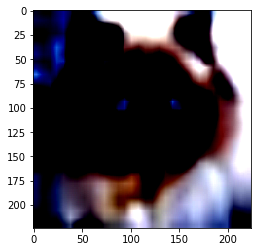

In [76]:
import numpy as np
import random
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  

#sample = test[random.randint(0, 10000)]
sample = train[random.randint(0, 10000)]
sample_label = sample[1]

img = np.transpose(sample[0], (1, 2, 0))
print("正解ラベル：", classes[sample[1]])
plt.imshow(img)

In [77]:
sample_img = sample[0].unsqueeze(0)
y_predict = net.forward(sample_img)
print(y_predict)
print("推論結果: ", classes[y_predict.argmax()])

tensor([[-0.1818, -1.3311,  0.6404,  0.2861,  0.4336,  0.7373, -0.7216,  0.3266,
         -0.9404, -1.0193]], grad_fn=<AddmmBackward>)
推論結果:  dog


In [14]:
torch.cuda.is_available()

True